<a href="https://colab.research.google.com/github/unchet/LABS/blob/main/Pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch.utils.data as data
import torch.optim as optim


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip oxpets_images.zip

unzip:  cannot find or open oxpets_images.zip, oxpets_images.zip.zip or oxpets_images.zip.ZIP.


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
url = 'drive/MyDrive/oxpets_images'

TRANSFORM_IMG = transforms.Compose([
                                    
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

data_ = torchvision.datasets.ImageFolder(root=url, transform=TRANSFORM_IMG)

In [6]:
data_

Dataset ImageFolder
    Number of datapoints: 951
    Root location: drive/MyDrive/oxpets_images
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
train_size = int(0.8 * len(data_))
test_size = len(data_) - train_size

In [8]:
train, test = torch.utils.data.random_split(data_, [train_size, test_size])

In [9]:
len(train), len(test)

(760, 191)

In [10]:
train_loader = data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test, batch_size=32, shuffle=False)

In [11]:
!pip install pretrainedmodels
import pretrainedmodels

class Net(nn.Module):
  def __init__(self):
        super(Net, self).__init__()
        self.model =  pretrainedmodels.__dict__['resnet18'](pretrained='imagenet')
        
        self.classifier_layer = nn.Sequential(
            nn.Linear(512 , 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256 , 128),
            nn.Linear(128 , 37)
        )
        
  def forward(self, x):
    batch_size ,_,_,_ = x.shape   
    x = self.model.features(x)
    x = torch.nn.functional.adaptive_avg_pool2d(x,1).reshape(batch_size,-1) 
    x = self.classifier_layer(x)
    return x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
net = Net()
net = net.to(device)
print(net)

Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [13]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):  
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('%d loss: %.3f' %(epoch + 1, loss.item()))
print('Finished Training')

1 loss: 3.199
2 loss: 1.387
3 loss: 0.033
4 loss: 0.007
5 loss: 0.003
Finished Training


In [14]:
from sklearn.metrics import confusion_matrix 
 
def get_confusion_matrix(model, loader): 
  y_pred = [] 
  y_true = [] 
 
  with torch.no_grad(): 
    for images, labels in loader: 
      images, labels = images.to(device), labels.to(device)
      outputs = model(images) 
      outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy() 
      y_pred.extend(outputs) 
        
      labels = labels.data.cpu().numpy() 
      y_true.extend(labels) 
  cnf = confusion_matrix(y_true, y_pred) 
  print(y_pred)
  print(y_true)
  return cnf


In [15]:
from sklearn.metrics import top_k_accuracy_score
def get_accuracy(model, loader):
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy {}%'.format(100 * correct / total))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

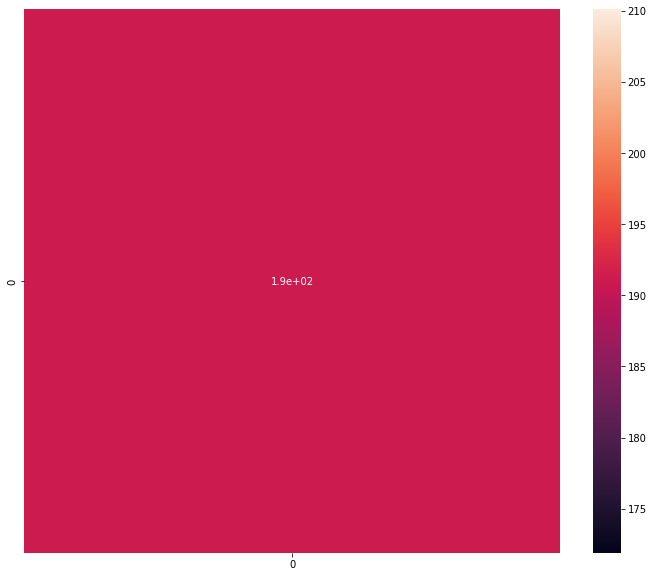

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cnf = get_confusion_matrix(net, test_loader)

df_cm = pd.DataFrame(cnf)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)

In [17]:
get_accuracy(net, test_loader)

Accuracy 100.0%


In [18]:
from torchvision import models

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 37)
vgg16 = vgg16.to(device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
criterion1 = nn.CrossEntropyLoss()
criterion1 = criterion.to(device)
optimizer1 = optim.Adam(vgg16.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):  
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer1.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
    print('%d loss: %.3f' %(epoch + 1, loss.item()))
print('Finished Training')

1 loss: 0.000
2 loss: 0.000
3 loss: 0.000
4 loss: 0.000
5 loss: 0.000
Finished Training


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

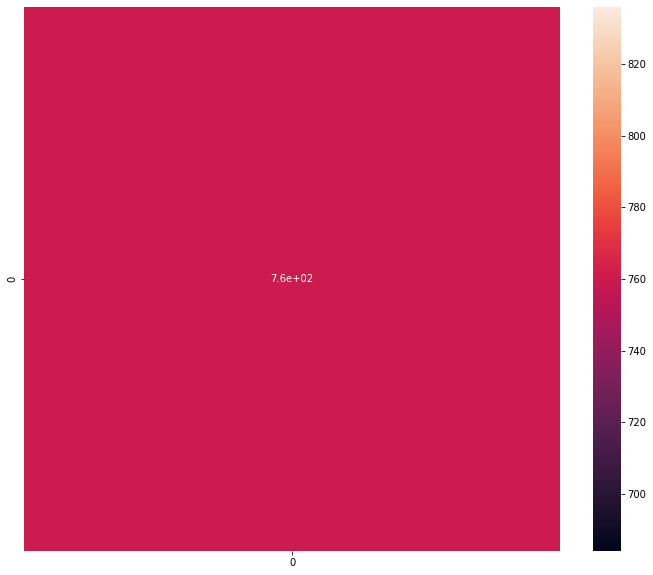

In [20]:
cnf = get_confusion_matrix(vgg16, train_loader)

df_cm = pd.DataFrame(cnf)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)

In [21]:
get_accuracy(vgg16, train_loader)

Accuracy 100.0%
